# Using Baseline Model — Logistic Regression


---



---




# Exploratory Data Analysis (EDA)
## Load & Prepare the Data

In [1]:
# install necessary tools/packages/libraries

# most of the required libraries are built-in in Google Colab.
# For different runtimes env, need to install the necessary external libraries.
# i'm just going for those are not available in colab

!pip install wordcloud

from google.colab import drive # using dataset from my drive filepath
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Load the datasets and store in my declared dataframes
train_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/test.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/test_labels.csv')

# Fine-grained labels from training data
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# Creating a binary 'offensive' (overally offensive) label in train.csv
train_df['offensive'] = train_df[label_cols].max(axis=1)

print(train_df.head())


                 id                                      feedback_text  toxic  \
0  281d77b7bebc2201  :::Sounds good.  Let me know when you're done ...      0   
1  716aac7bf3c63db1  "\nI say something, but it didn't actually con...      0   
2  57cb318c6edcf10c  "Agustina Barrientos]] \n | Modelo de Piñeiro ...      0   
3  dc3bd70118d91b3a  FYI I enjoy licking strangers scrotal sacks......      1   
4  cf10d41f2997d233  How do you get a site?\nMany penguins have ask...      0   

   abusive  vulgar  menace  offense  bigotry  offensive  
0        0       0       0        0        0          0  
1        0       0       0        0        0          0  
2        0       0       0        0        0          0  
3        0       1       0        0        0          1  
4        0       0       0        0        0          0  


## Data exporation and analysis

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Checking for missing values
print("🔍 Missing Values:\n")
print(train_df.isnull().sum())

🔍 Missing Values:

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
offensive        0
dtype: int64


<ipython-input-4-944c008a5d78>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


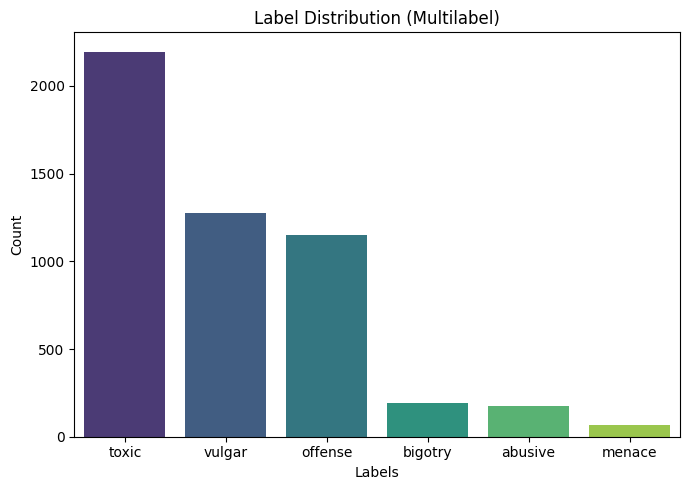

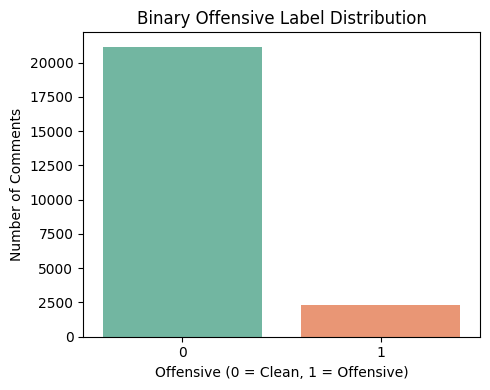

In [4]:
# so no issue with missing values

# Visualize label distribution across all toxicity types
label_counts = train_df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution (Multilabel)')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.tight_layout()
plt.show()

# Visualize my definedd binary 'offensive' label distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='offensive', data=train_df, hue='offensive', palette='Set2', legend=False)
plt.title('Binary Offensive Label Distribution')
plt.xlabel('Offensive (0 = Clean, 1 = Offensive)')
plt.ylabel('Number of Comments')
plt.tight_layout()
plt.show()


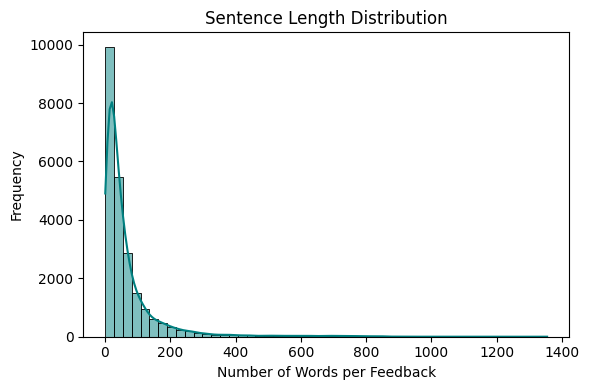

In [5]:
# Analyze sentence length
train_df['text_length'] = train_df['feedback_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='teal')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words per Feedback')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Text Preprocessing


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


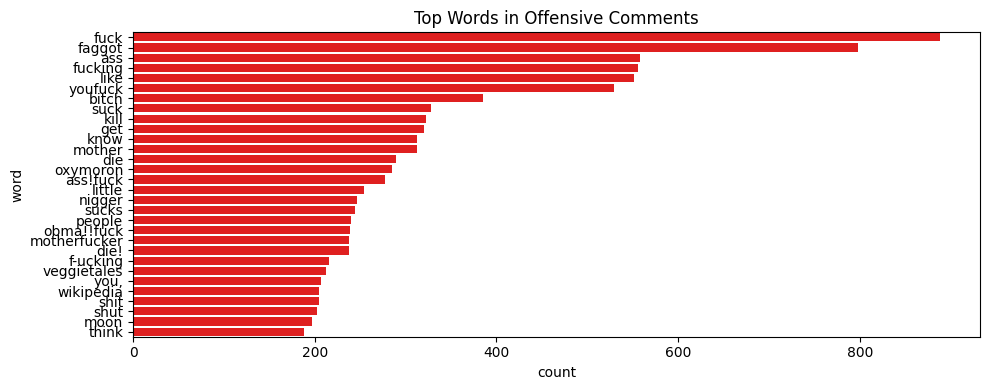

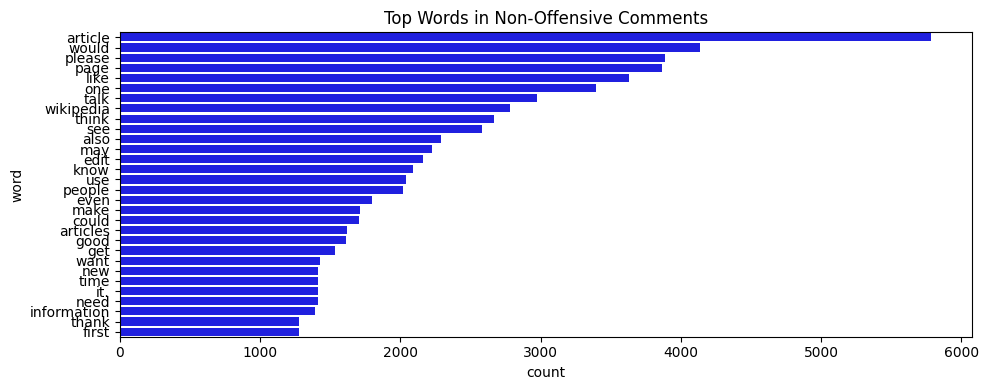

In [6]:

# import necessary modules for text preprocessing and word frequency analysis

import nltk; nltk.download('stopwords') # Download NLTK stopwords
from collections import Counter
from nltk.corpus import stopwords

# Most common words in offensive vs non-offensive comments

stop_words = set(stopwords.words('english'))

def get_common_words(text_series, top_n=30):
    words = ' '.join(text_series).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(top_n)

# Top words in offensive and non-offensive comments
offensive_words = get_common_words(train_df[train_df['offensive'] == 1]['feedback_text'])
non_offensive_words = get_common_words(train_df[train_df['offensive'] == 0]['feedback_text'])

# Convert to DataFrames
off_df = pd.DataFrame(offensive_words, columns=['word', 'count'])
non_off_df = pd.DataFrame(non_offensive_words, columns=['word', 'count'])

# Barplot – offensive
plt.figure(figsize=(10, 4))
sns.barplot(data=off_df, x='count', y='word', color='red')  # use 'color' instead of palette to avoid warning
plt.title('Top Words in Offensive Comments')
plt.tight_layout()
plt.show()

# Barplot – non-offensive
plt.figure(figsize=(10, 4))
sns.barplot(data=non_off_df, x='count', y='word', color='blue')
plt.title('Top Words in Non-Offensive Comments')
plt.tight_layout()
plt.show()

# WordCloud of offensive comments
# from wordcloud import WordCloud

# offensive_text = ' '.join(train_df[train_df['offensive'] == 1]['feedback_text'])
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(offensive_text)

# plt.figure(figsize=(12, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('WordCloud of Offensive Comments')
# plt.tight_layout()
# plt.show()


In [7]:
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define my text cleaning function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove non-word characters (punctuation, special symbols)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization + Stopword removal + Lemmatization
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return " ".join(tokens)

# Apply preprocessing
train_df['clean_text'] = train_df['feedback_text'].apply(preprocess_text)
val_df['clean_text'] = val_df['feedback_text'].apply(preprocess_text)
test_df['clean_text'] = test_df['content'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
# TF-IDF Feature extraction using unigrams and bigrams
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

# Fit on training data and transform all sets
X_train = tfidf.fit_transform(train_df['clean_text'])
X_val = tfidf.transform(val_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])

# Labels for training
y_train = train_df['offensive']

# # Rename toxic column to offensive in validation set
# val_df.rename(columns={'toxic': 'offensive'}, inplace=True)

# Labels for validation
y_val = val_df['toxic']


# Model Creation
## Logistic Regression (Binary Classification)
This model will classify a comment/feedback as overally offensive (1) or non-offensive (0).

In [9]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=33)

# Train the model on TF-IDF features and offensive labels
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=33)

In [10]:
# Predict on Validation Set

y_val_pred = model.predict(X_val)

# Predict probabilities (for ROC curve and AUC)
y_val_prob = model.predict_proba(X_val)[:, 1]

# Model Evaluation

In [11]:
# Evaluate with Accuracy, F1, Precision, Recall, AUC

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"AUC-ROC Score: {roc_auc_score(y_val, y_val_prob):.3f}")


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       706
           1       0.53      0.07      0.13       134

    accuracy                           0.84       840
   macro avg       0.69      0.53      0.52       840
weighted avg       0.80      0.84      0.79       840

Accuracy: 0.842
AUC-ROC Score: 0.620


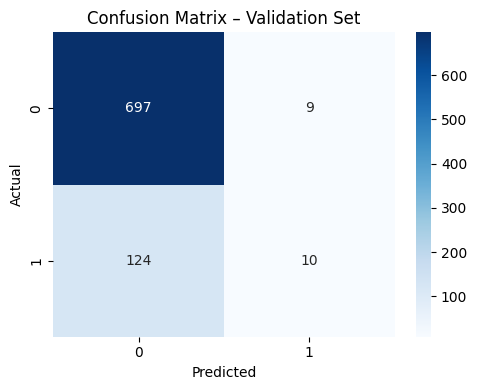

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


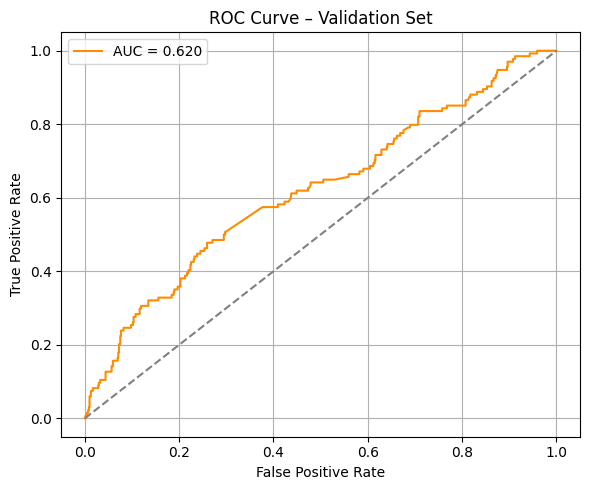

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## evaluate on test set

In [14]:
# Predict on test set

# Merge the 'offensive' labels from test_labels_df into test_df based on 'id'
test_df = test_df.merge(
    test_labels_df[['id', 'toxic']],
    on='id',
    how='left'
)

y_test= test_labels_df['toxic']

test_pred = model.predict(X_test)
test_prob = model.predict_proba(X_test)[:, 1]


Classification Report – Test Set:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      4637
           1       0.43      0.04      0.07      1363

    accuracy                           0.77      6000
   macro avg       0.60      0.51      0.47      6000
weighted avg       0.70      0.77      0.69      6000

Accuracy: 0.770
AUC-ROC Score: 0.540


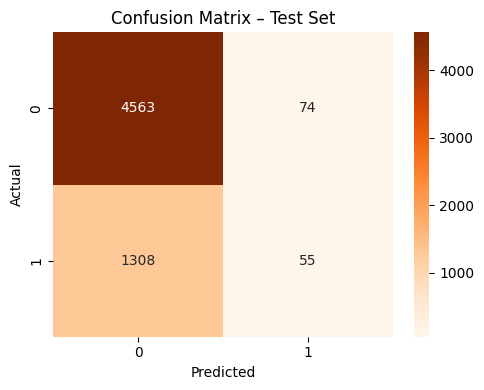

In [15]:
# Classification Report
print("Classification Report – Test Set:")
print(classification_report(y_test, test_pred))

print(f"Accuracy: {accuracy_score(y_test, test_pred):.3f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, test_prob):.3f}")


# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


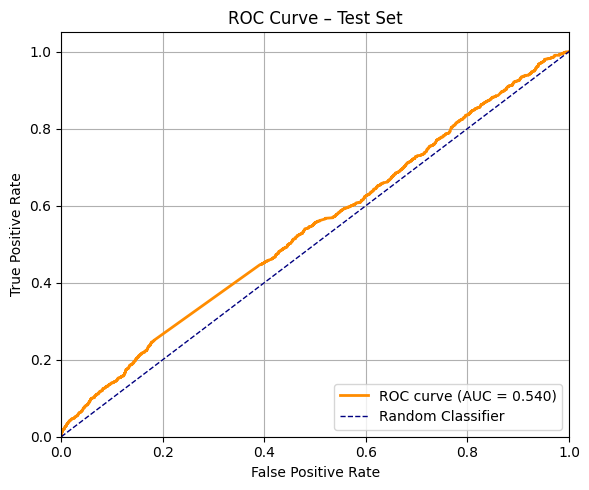

In [16]:
# ROC curve from probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



---



---


# LSTM Model



In [17]:
# Tokenization & Padding

!pip install tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [18]:
# Combine all text to fit tokenizer on full vocabulary
all_texts = pd.concat([train_df['clean_text'], val_df['clean_text'], test_df['clean_text']])

# Tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences
MAX_LEN = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Labels
y_train_seq = train_df['offensive']
y_val_seq = val_df['toxic']

In [19]:
# Build LSTM Model with Embedding

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

vocab_size = 20000
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN),
    LSTM(128, return_sequences=True),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Compile and Train Model

from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
    X_train_pad, y_train_seq,
    validation_data=(X_val_pad, y_val_seq),
    epochs=6,
    batch_size=64,
    verbose=1
)

Epoch 1/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 159s 386ms/step - accuracy: 0.8932 - loss: 0.3377 - val_accuracy: 0.8071 - val_loss: 0.5280
Epoch 2/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 107s 291ms/step - accuracy: 0.9511 - loss: 0.1343 - val_accuracy: 0.8167 - val_loss: 0.5056
Epoch 3/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 140s 286ms/step - accuracy: 0.9695 - loss: 0.0884 - val_accuracy: 0.6202 - val_loss: 0.6734
Epoch 4/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 101s 275ms/step - accuracy: 0.9807 - loss: 0.0562 - val_accuracy: 0.5012 - val_loss: 1.1852
Epoch 5/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 141s 272ms/step - accuracy: 0.9872 - loss: 0.0387 - val_accuracy: 0.4560 - val_loss: 1.2134
Epoch 6/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 143s 274ms/step - accuracy: 0.9923 - loss: 0.0262 - val_accuracy: 0.7417 - val_loss: 0.8997


# Model Evaluation

In [21]:
# Predict on Validation Set

y_val_pred_prob = model.predict(X_val_pad)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Classification Report + AUC

print("Classification Report – LSTM:")
print(classification_report(y_val_seq, y_val_pred))

print(f"Accuracy: {accuracy_score(y_val_seq, y_val_pred):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_val_seq, y_val_pred_prob):.3f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Classification Report – LSTM:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       706
           1       0.19      0.19      0.19       134

    accuracy                           0.74       840
   macro avg       0.52      0.52      0.52       840
weighted avg       0.74      0.74      0.74       840

Accuracy: 0.742
AUC-ROC: 0.509


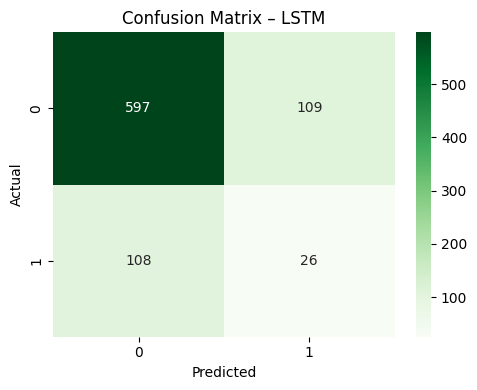

In [22]:
cm = confusion_matrix(y_val_seq, y_val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


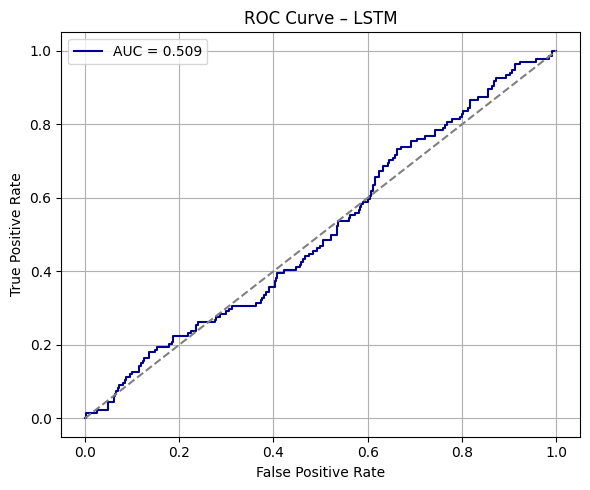

In [23]:
fpr, tpr, _ = roc_curve(y_val_seq, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Model Tuning & Optimization

Skip(comment out) the model running portion as the model will be saved to avoid runtime delay

In [24]:
# Using Keras Tuner, i'm  experiment with different values for:
# Optimizers, Learning rate, LSTM units, Dropout, Batch size, Activation functions

!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.optimizers import RMSprop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [25]:
# Defining a Model-Building Function
# This is where you set the searchable hyperparameters using hp:

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=20000, output_dim=hp.Choice('embedding_dim', [64, 100, 128]), input_length=100))
    model.add(LSTM(units=hp.Choice('lstm_units', [64, 128, 256]), return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=hp.Choice('dropout', [0.3, 0.5])))
    model.add(Dense(units=hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [26]:
# Initialize the Tuner, use RandomSearch

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='offensive_lstm_tuning'
)

# Run the Tuning

tuner.search(X_train_pad, y_train_seq,
             epochs=5,
             validation_data=(X_val_pad, y_val_seq),
             batch_size=64)

Trial 6 Complete [00h 05m 11s]
val_accuracy: 0.8440476059913635

Best val_accuracy So Far: 0.8452380895614624
Total elapsed time: 01h 01m 38s


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")


Best Hyperparameters:
LSTM Units: 64
Dropout: 0.5
Optimizer: adam
Dense Units: 32
Embedding Dim: 128


In [32]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

# Best hyperparameters from Keras Tuner
lstm_units = 64            # Number of LSTM units
dropout_rate = 0.5         # Dropout rate after LSTM
optimizer = 'adam'         # Optimizer (used during compilation)
dense_units = 128          # Number of neurons in dense layer
embedding_dim = 128        # Size of word embedding vectors
max_len = 100              # Maximum sequence length (same as your padding length)
vocab_size = 20000         # Vocabulary size from Tokenizer

# Final LSTM model with best parameters
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=lstm_units, return_sequences=True),
    GlobalMaxPooling1D(),
    Dropout(rate=dropout_rate),
    Dense(units=dense_units, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification (offensive or not)
])

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


In [33]:
history = model.fit(
    X_train_pad, y_train_seq,
    validation_data=(X_val_pad, y_val_seq),
    epochs=6,
    batch_size=64
)

Epoch 1/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 90s 219ms/step - accuracy: 0.9067 - loss: 0.3183 - val_accuracy: 0.8369 - val_loss: 0.4596
Epoch 2/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 70s 191ms/step - accuracy: 0.9539 - loss: 0.1277 - val_accuracy: 0.6393 - val_loss: 0.6575
Epoch 3/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 71s 193ms/step - accuracy: 0.9707 - loss: 0.0828 - val_accuracy: 0.6119 - val_loss: 0.9826
Epoch 4/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 95s 230ms/step - accuracy: 0.9798 - loss: 0.0573 - val_accuracy: 0.5750 - val_loss: 1.1921
Epoch 5/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 130s 197ms/step - accuracy: 0.9875 - loss: 0.0383 - val_accuracy: 0.4262 - val_loss: 2.2874
Epoch 6/6
367/367 ━━━━━━━━━━━━━━━━━━━━ 85s 205ms/step - accuracy: 0.9912 - loss: 0.0261 - val_accuracy: 0.5631 - val_loss: 1.5972


In [34]:
# Save my entire model
model.save('/content/lstm_offensive_class_model.h5')


In [35]:
# Predict on test set

# test_pred = model.predict(X_test)
# test_prob = model.predict_proba(X_test)[:, 1]

# Predict probabilities and labels
test_pred_prob = model.predict(X_test_pad).flatten()
test_pred = (test_pred_prob >= 0.5).astype(int)


188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step



Classification Report – LSTM Test Set:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4637
           1       0.18      0.20      0.19      1363

    accuracy                           0.62      6000
   macro avg       0.47      0.47      0.47      6000
weighted avg       0.63      0.62      0.62      6000

Accuracy: 0.618
AUC-ROC Score: 0.457


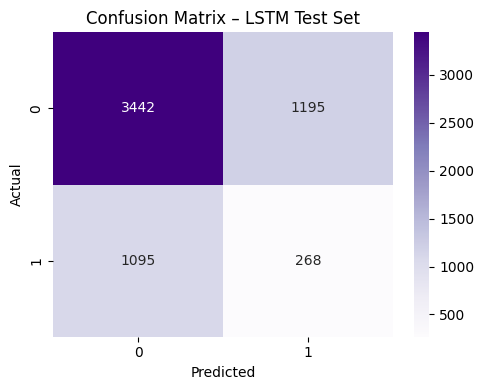

In [40]:
print("\nClassification Report – LSTM Test Set:")
print(classification_report(y_test, test_pred))

print(f"Accuracy: {accuracy_score(y_test, test_pred):.3f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, test_pred_prob[:len(y_test)]):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – LSTM Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()




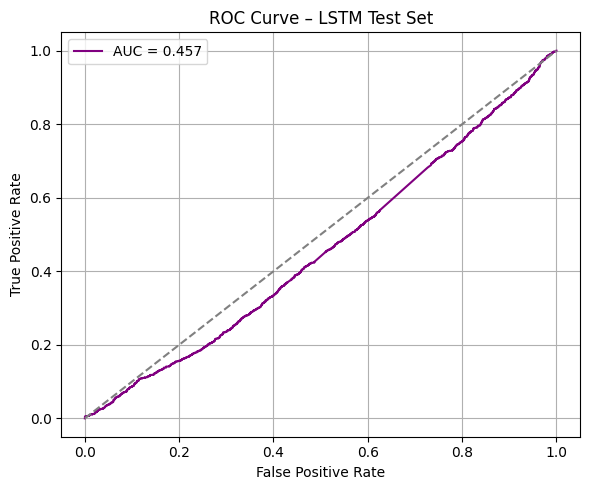

In [41]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_pred_prob[:len(y_test)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – LSTM Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()